# **Predicting incidents** 

# Necessary libraries & datasets

First, we load all the packages that are needed for the project:

In [1]:
# Standard libraries
import datetime, warnings
import time
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from pprint import pprint

# Applicable sklearn libraries
from sklearn import metrics, linear_model, tree
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold

# XGBoost 
from xgboost import XGBRegressor

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

C:\Users\richa\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_features = pd.read_csv('all_features.csv')
print('Dataframe dimensions:', df_features.shape)
df_features

Dataframe dimensions: (479, 66)


,Unnamed: 0,BuurtCode,Neighborhood,TotalResidents,Age 0-15,% age 0-15,Age 65+,%Age 65+,AverageSizeofHoushold,Population Density,Building year before 2000,Building year after 2000,woning,horeca,winkel,bedrijf_en_kantoor,kerk_en_gebedsruimte,cultuur_en_musea,medisch,bejaardenhuis_tehuis_en_bijzondere_woonfunctie,kinderdagverblijf_en_basisschool,middelbaar_en_speciaal_onderwijs,beroeps_en_wetenschappelijk_onderwijs,garage_en_parkeerplaats,nr_of_rent,...,nr_of_inspections_without_observation,industrie,sport,x,y,lon,lat,gem_gas_woning,gem_gas_woning_cor,gem_elektriciteit_woning,gem_gas_bedrijf,gem_elektriciteit_bedrijf,potent_pand_asbest,gebouwen_gebruik_gas,meer_reg_woning,meer_reg_industrie,hoge_gas_verbruik,hoge_asbest_buurt,hoge_dichtheid_buurt,industrie_buurt,industriegebied,env_effect,Supermarkt,Verzorghuizen,Museum
0,0,BU03630000,Kop Zeedijk,1110.0,45.0,4.054054,100.0,9.009009,1.4,18349,96.0,4.0,162.0,120.0,29.0,18.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,195.0,...,24.0,20.0,0.0,121824.740361,487631.554156,4.900018,52.375553,791.0,918.0,1695.0,3402.0,17082.0,19.0,1035.0,743.0,10.0,0.0,1.0,0.0,1.0,1.0,3.0,NaN,NaN,NaN
1,1,BU03630001,Oude Kerk e.o.,695.0,20.0,2.877698,70.0,10.071942,1.4,7910,87.0,13.0,101.0,43.0,24.0,73.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,150.0,...,52.0,106.0,0.0,121595.371677,487447.889546,4.896668,52.373888,732.0,850.0,1591.0,5048.0,31608.0,32.0,765.0,513.0,102.0,0.0,1.0,0.0,1.0,1.0,3.0,NaN,NaN,NaN
2,2,BU03630002,Burgwallen Oost,1645.0,90.0,5.471125,180.0,10.942249,1.4,26460,96.0,4.0,274.0,47.0,53.0,73.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,298.0,...,30.0,41.0,0.0,121736.890103,487329.844480,4.898758,52.372836,901.0,1045.0,1816.0,2571.0,12513.0,25.0,1459.0,1027.0,32.0,0.0,1.0,1.0,1.0,1.0,4.0,NaN,NaN,NaN
3,3,BU03630003,Nes e.o.,365.0,25.0,6.849315,30.0,8.219178,1.5,6883,98.0,2.0,53.0,48.0,41.0,74.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,111.0,...,33.0,12.0,0.0,121415.085604,487117.492764,4.894054,52.370908,882.0,1021.0,1745.0,4927.0,30261.0,4.0,425.0,240.0,3.0,0.0,0.0,0.0,1.0,1.0,2.0,NaN,NaN,NaN
4,4,BU03630004,BG-terrein e.o.,690.0,40.0,5.797101,80.0,11.594203,1.4,8161,100.0,0.0,97.0,18.0,8.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,1.0,97.0,...,45.0,8.0,0.0,121534.142532,487008.012912,4.895813,52.369931,954.0,1108.0,1880.0,4356.0,24764.0,0.0,515.0,367.0,4.0,0.0,0.0,0.0,1.0,1.0,2.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,474,BU03639701,Gein Zuidwest,1665.0,310.0,18.618619,125.0,7.507508,1.9,9544,100.0,0.0,209.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,...,1.0,2.0,0.0,127571.049934,478601.865966,4.985137,52.294716,964.0,1118.0,2089.0,0.0,381.0,0.0,755.0,747.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
475,475,BU03639702,Gein Noordoost,3245.0,450.0,13.867488,660.0,20.338983,2.3,5109,100.0,0.0,147.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,...,0.0,0.0,0.0,128208.920095,479088.995253,4.994448,52.299125,989.0,1147.0,3025.0,0.0,0.0,0.0,1264.0,1245.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN
476,476,BU03639703,Gein Zuidoost,3355.0,510.0,15.201192,630.0,18.777943,2.0,4676,100.0,0.0,266.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,218.0,...,0.0,0.0,0.0,127916.351954,478425.038846,4.990213,52.293144,1009.0,1171.0,2458.0,0.0,0.0,0.0,1563.0,1527.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,NaN,NaN,NaN
477,477,BU03639800,Dorp Driemond,1480.0,265.0,17.905405,275.0,18.581081,2.3,5099,94.0,6.0,92.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,57.0,...,2.0,4.0,0.0,129716.746223,479805.037571,5.016499,52.305632,1120.0,1301.0,2837.0,0.0,871.0,249.0,676.0,630.0,3.0,1.0,1.0,0.0,1.0,1.0,4.0,NaN,NaN,NaN


In [3]:
pd.set_option('display.max_rows', 73)
df_features.dtypes

Unnamed: 0                                          int64
BuurtCode                                          object
Neighborhood                                       object
TotalResidents                                    float64
Age 0-15                                          float64
% age 0-15                                        float64
Age 65+                                           float64
%Age 65+                                          float64
AverageSizeofHoushold                              object
Population Density                                 object
Building year before 2000                         float64
Building year after 2000                          float64
woning                                            float64
horeca                                            float64
winkel                                            float64
bedrijf_en_kantoor                                float64
kerk_en_gebedsruimte                              float64
cultuur_en_mus

___
## 1. Cleaning
___
### 1.1 Filling factor

Examining how complete the dataset is: 

In [4]:
missing_df = df_features.isnull().sum(axis = 0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)'] = (df_features.shape[0] - missing_df['missing values'])/df_features.shape[0] * 100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)
missing_df

,variable,missing values,filling factor (%)
0,Unnamed: 0,0,100.000000
1,BuurtCode,0,100.000000
2,Neighborhood,0,100.000000
3,TotalResidents,0,100.000000
4,Age 0-15,0,100.000000
5,% age 0-15,19,96.033403
6,Age 65+,0,100.000000
7,%Age 65+,18,96.242171
8,AverageSizeofHoushold,0,100.000000
9,Population Density,0,100.000000


As you can see, there are some missing values within the dataset, so these ones will be encoded to 0 instead of NaN. 

In [5]:
df_features = df_features.fillna(0)

missing_df = df_features.isnull().sum(axis = 0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)'] = (df_features.shape[0] - missing_df['missing values'])/df_features.shape[0] * 100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)
missing_df

,variable,missing values,filling factor (%)
0,Unnamed: 0,0,100.0
1,BuurtCode,0,100.0
2,Neighborhood,0,100.0
3,TotalResidents,0,100.0
4,Age 0-15,0,100.0
5,% age 0-15,0,100.0
6,Age 65+,0,100.0
7,%Age 65+,0,100.0
8,AverageSizeofHoushold,0,100.0
9,Population Density,0,100.0


In [6]:
df_features = df_features.replace('       .', np.nan)

Now everything is filled up and '       .' are converted to NaN. 

### 1.2 Data preprocessing


In [7]:
# See which features have a contribution to the "incident" and which not within the features set

corr_matrix = df_features.corr()
corr_matrix['incident'].sort_values(ascending = False)

incident                                          1.000000
TotalResidents                                    0.708279
meer_reg_woning                                   0.705561
nr_of_rent                                        0.691520
gebouwen_gebruik_gas                              0.664756
woning                                            0.649700
hoge_dichtheid_buurt                              0.608791
Age 0-15                                          0.601165
nr_of_tussengebouw                                0.591267
Age 65+                                           0.544678
nr_of_possession                                  0.533107
nr_of_hoekgebouw                                  0.407846
winkel                                            0.393295
potent_pand_asbest                                0.385004
env_effect                                        0.354403
nr_of_monuments                                   0.316398
Building year before 2000                         0.3130

In [8]:
df_features_clean = df_features[["TotalResidents", "% age 0-15", "%Age 65+", "AverageSizeofHoushold", "Population Density", 
                                 "Building year before 2000", "floorsize_accomodation", "env_effect", "nr_of_monuments", 
                                 "cultuur_en_musea", "incident"]].copy()
df_features_clean

,TotalResidents,% age 0-15,%Age 65+,AverageSizeofHoushold,Population Density,Building year before 2000,floorsize_accomodation,env_effect,nr_of_monuments,cultuur_en_musea,incident
0,1110.0,4.054054,9.009009,1.4,18349,96.0,1716.0,3.0,20.0,4.0,3.0
1,695.0,2.877698,10.071942,1.4,7910,87.0,117.0,3.0,23.0,3.0,8.0
2,1645.0,5.471125,10.942249,1.4,26460,96.0,86.0,4.0,12.0,2.0,8.0
3,365.0,6.849315,8.219178,1.5,6883,98.0,442.0,2.0,69.0,1.0,5.0
4,690.0,5.797101,11.594203,1.4,8161,100.0,680.0,2.0,32.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
474,1665.0,18.618619,7.507508,1.9,9544,100.0,93.0,0.0,0.0,1.0,3.0
475,3245.0,13.867488,20.338983,2.3,5109,100.0,80.0,1.0,0.0,0.0,6.0
476,3355.0,15.201192,18.777943,2.0,4676,100.0,74.0,2.0,0.0,0.0,7.0
477,1480.0,17.905405,18.581081,2.3,5099,94.0,73.0,4.0,0.0,0.0,0.0


We also need to check if there are infinite values that need to be converted. That is something which will be done with the function below. 

In [9]:
def clean_data(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a dataframe"
    df.dropna(inplace = True)
    indices = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices].astype(np.float64)

In [10]:
df_features_clean = clean_data(df_features_clean)

In [11]:
X = df_features_clean.drop(columns = 'incident')
X[['AverageSizeofHoushold', 'Population Density']] = X[['AverageSizeofHoushold', 'Population Density']].astype(float)

y = df_features_clean.incident

___
## 2. Predicting incidents
### 2.1 Train-test split (hold-out)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.35)

### 2.1.1 XGBoost

In [13]:
start_time = time.time()

reg_xgb = XGBRegressor()
reg_xgb.fit(X_train, y_train)

finish_time = time.time()
total_time = finish_time - start_time

print('Elapsed time: ', total_time)

Elapsed time:  0.21412110328674316


In [14]:
y_pred = reg_xgb.predict(X_test)

In [15]:
reg_xgb.score(X_train, y_train)

0.9999978515028485

In [16]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 2.2935267438174813
MSE: 10.431101578571516
RMSE: 3.2297215945916324


In [17]:
feature_list = list(X_train.columns)

# Get numerical feature importances
importances = list(reg_xgb.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: TotalResidents       Importance: 0.30000001192092896
Variable: nr_of_monuments      Importance: 0.20000000298023224
Variable: Population Density   Importance: 0.10999999940395355
Variable: cultuur_en_musea     Importance: 0.10999999940395355
Variable: AverageSizeofHoushold Importance: 0.10000000149011612
Variable: %Age 65+             Importance: 0.03999999910593033
Variable: Building year before 2000 Importance: 0.03999999910593033
Variable: floorsize_accomodation Importance: 0.03999999910593033
Variable: env_effect           Importance: 0.03999999910593033
Variable: % age 0-15           Importance: 0.029999999329447746


[None, None, None, None, None, None, None, None, None, None]

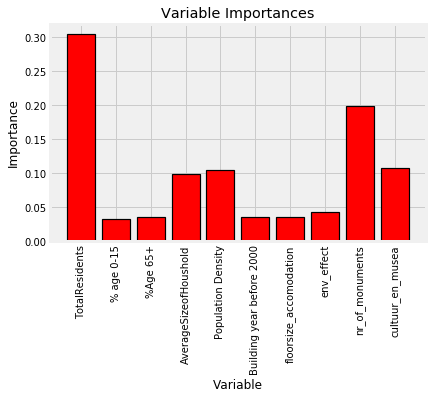

In [18]:
# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

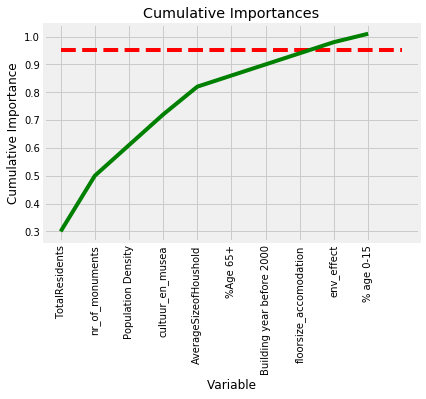

In [19]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [20]:
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 9


### 2.2 Using Cross-validation
### 2.2.1 XGBoost (5-fold)

In [21]:
start_time = time.time()

fold = KFold(n_splits = 5, shuffle = True, random_state = 100) 

hyper_params = [{'n_features_to_select': list(range(1, 10))}]

xgb_cv = RFE(reg_xgb)             

reg_xgb_cv = GridSearchCV(estimator = xgb_cv, 
                          param_grid = hyper_params,
                          scoring = 'r2',
                          cv = fold,
                          verbose = 1,
                          return_train_score = True)      

reg_xgb_cv.fit(X_train, y_train)   

finish_time = time.time()
total_time = finish_time - start_time

print('Elapsed time: ', total_time)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   25.8s finished


Elapsed time:  26.208736658096313


In [22]:
cv_result = pd.DataFrame(reg_xgb_cv.cv_results_)
cv_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.720102,0.041556,0.002400,0.000490,1,{'n_features_to_select': 1},0.371764,0.000562,-0.025890,0.172007,0.147012,0.133091,0.142487,9,0.922254,0.918276,0.923370,0.921696,0.950228,0.927165,1.165646e-02
1,0.690115,0.025146,0.003001,0.000894,2,{'n_features_to_select': 2},0.490556,0.230691,0.090625,-0.083620,0.274812,0.200613,0.191501,8,0.995039,0.989592,0.971436,0.994164,0.999396,0.989925,9.754808e-03
2,0.739601,0.137553,0.002800,0.000399,3,{'n_features_to_select': 3},0.418022,0.337364,0.330554,-0.149219,0.334798,0.254304,0.204366,6,0.996100,0.991190,0.991388,0.996059,0.999461,0.994840,3.151776e-03
3,0.803415,0.032659,0.003802,0.000742,4,{'n_features_to_select': 4},0.076710,0.200050,0.356314,0.192092,0.411805,0.247394,0.121101,7,0.999912,0.999364,0.998265,0.999546,0.999758,0.999369,5.827026e-04
4,0.703521,0.058707,0.003402,0.000490,5,{'n_features_to_select': 5},0.007426,0.321238,0.339831,0.249349,0.363610,0.256291,0.130151,5,0.999972,0.999968,0.999898,0.999903,0.999973,0.999943,3.446178e-05
5,0.541482,0.010561,0.003800,0.000749,6,{'n_features_to_select': 6},0.012126,0.337118,0.471425,0.392647,0.366000,0.315863,0.158314,4,0.999984,0.999994,0.999977,0.999978,0.999995,0.999986,7.932620e-06
6,0.426903,0.031207,0.003200,0.000400,7,{'n_features_to_select': 7},0.116704,0.378492,0.380510,0.451393,0.450132,0.355446,0.123554,2,0.999995,0.999998,0.999990,0.999993,0.999997,0.999995,2.709699e-06
7,0.318800,0.024251,0.003801,0.000749,8,{'n_features_to_select': 8},0.375386,0.206986,0.408542,0.454950,0.396997,0.368572,0.084880,1,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,2.467583e-07
8,0.166399,0.003005,0.003399,0.000490,9,{'n_features_to_select': 9},0.069318,0.269352,0.426657,0.474942,0.350773,0.318209,0.142633,3,0.999999,1.000000,0.999999,0.999997,1.000000,0.999999,8.459130e-07


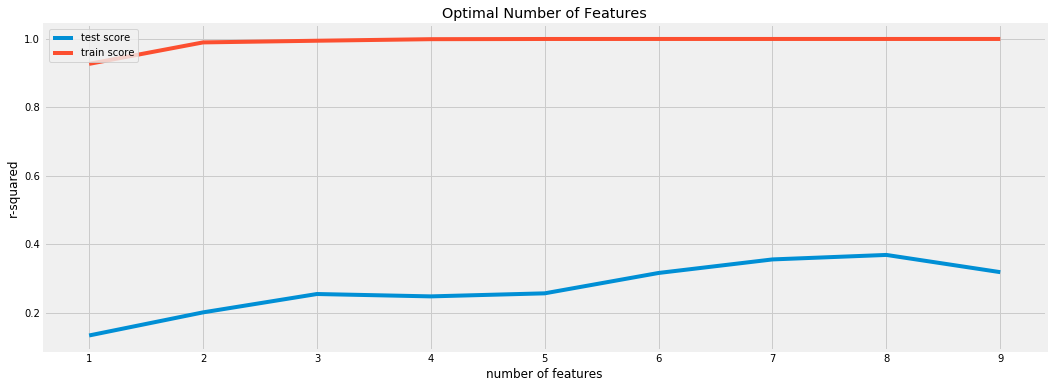

In [23]:
plt.figure(figsize = (16,6))

plt.plot(cv_result["param_n_features_to_select"], cv_result["mean_test_score"])
plt.plot(cv_result["param_n_features_to_select"], cv_result["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [24]:
# Final model - XGBoost
start_time = time.time()

n_optimal = 8

rfe = RFE(reg_xgb, n_features_to_select = n_optimal)             
reg_xgb_optima = rfe.fit(X_train, y_train)

finish_time = time.time()
total_time = finish_time - start_time

print('Elapsed time: ', total_time)

Elapsed time:  0.2799994945526123


In [25]:
# R2 score model with hold-out set 
print(metrics.r2_score(y_train, reg_xgb.predict(X_train)))
print(metrics.r2_score(y_test, reg_xgb.predict(X_test)))

0.9999978515028485
0.4041698001737801


In [26]:
# R2 score model with optimal XGBoost model 
print(metrics.r2_score(y_train, reg_xgb_optima.predict(X_train)))
print(metrics.r2_score(y_test, reg_xgb_optima.predict(X_test)))

0.999991186684509
0.4121794862826327


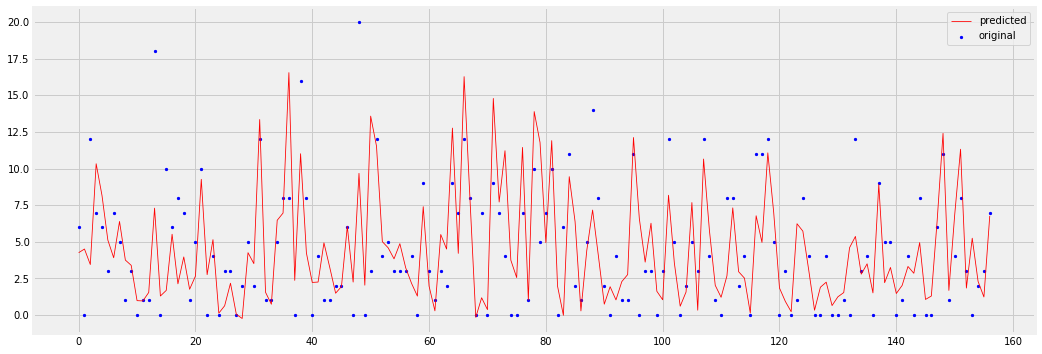

In [27]:
plt.figure(figsize = (16,6))

x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s = 5, color = "blue", label = "original")
plt.plot(x_ax, reg_xgb_optima.predict(X_test), lw = 0.8, color = "red", label = "predicted")
plt.legend()
plt.show()

### 2.2.2 XGBoost (10-fold, didn't perform better in comparison to 5-fold)

In [28]:
start_time = time.time()

fold = KFold(n_splits = 10, shuffle = True, random_state = 100) 

hyper_params = [{'n_features_to_select': list(range(1, 10))}]

xgb_cv = RFE(reg_xgb)             

reg_xgb_cv_10 = GridSearchCV(estimator = xgb_cv, 
                          param_grid = hyper_params,
                          scoring = 'r2',
                          cv = fold,
                          verbose = 1,
                          return_train_score = True)      

reg_xgb_cv_10.fit(X_train, y_train)   

finish_time = time.time()
total_time = finish_time - start_time

print('Elapsed time: ', total_time)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   57.2s finished


Elapsed time:  57.60830903053284


In [29]:
cv_result = pd.DataFrame(reg_xgb_cv_10.cv_results_)
cv_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,1.046285,0.009874,0.003300,0.000459,1,{'n_features_to_select': 1},0.183759,0.588483,0.412837,-0.451948,-1.043462,0.284799,0.371606,-0.174704,-0.240380,0.220182,0.015117,0.468752,9,0.921670,0.913260,0.913828,0.916637,0.925579,0.912551,0.914224,0.918790,0.945809,0.940609,0.922296,0.011212
1,0.953589,0.010017,0.003400,0.000489,2,{'n_features_to_select': 2},0.589752,0.479433,0.526520,0.571334,-0.531718,0.202122,0.311630,-0.029037,0.089349,0.149885,0.235927,0.328127,7,0.993498,0.989301,0.965486,0.988852,0.990683,0.969348,0.970419,0.993166,0.988345,0.988912,0.983801,0.010271
2,0.865760,0.019714,0.003607,0.000496,3,{'n_features_to_select': 3},0.595056,0.257183,0.087342,0.597542,-0.157446,0.468936,0.215726,-0.074361,0.463195,0.245365,0.269854,0.250643,6,0.995291,0.991170,0.989510,0.990977,0.991781,0.989914,0.990363,0.995095,0.999507,0.990918,0.992453,0.003015
3,0.750825,0.009408,0.003200,0.000400,4,{'n_features_to_select': 4},0.449413,0.288093,-0.225580,0.545483,-0.142870,0.533616,0.007537,-0.221054,0.437544,0.393728,0.206591,0.301190,8,0.999800,0.999219,0.999289,0.999734,0.999565,0.997660,0.999742,0.997057,0.999643,0.999772,0.999148,0.000924
4,0.641244,0.010167,0.003300,0.000459,5,{'n_features_to_select': 5},0.522281,0.428615,0.182771,0.589216,-0.191895,0.602099,0.289687,0.291647,0.517630,0.347130,0.357918,0.226446,5,0.999947,0.999954,0.999948,0.999945,0.999844,0.999852,0.999941,0.999893,0.999929,0.999916,0.999917,0.000039
5,0.526232,0.006806,0.003400,0.000491,6,{'n_features_to_select': 6},0.545947,0.454060,0.139361,0.558092,-0.026340,0.478596,0.303210,0.404041,0.540581,0.325365,0.372291,0.182245,4,0.999966,0.999974,0.999992,0.999963,0.999973,0.999966,0.999977,0.999917,0.999960,0.999941,0.999963,0.000020
6,0.413887,0.008528,0.003701,0.000641,7,{'n_features_to_select': 7},0.489557,0.539421,0.013421,0.449082,0.131996,0.369063,0.351121,0.605564,0.531430,0.278020,0.375867,0.179741,3,0.999994,0.999983,0.999990,0.999983,0.999989,0.999990,0.999988,0.999978,0.999988,0.999992,0.999988,0.000005
7,0.291260,0.004773,0.003601,0.000664,8,{'n_features_to_select': 8},0.504037,0.544193,0.071053,0.547302,0.230678,0.407007,0.401522,0.595691,0.477009,0.318552,0.409704,0.154970,1,0.999993,0.999996,0.999998,0.999998,0.999997,0.999997,0.999996,0.999995,0.999995,0.999994,0.999996,0.000002
8,0.171510,0.003943,0.003001,0.000001,9,{'n_features_to_select': 9},0.590786,0.486655,0.241254,0.405708,0.197596,0.437836,0.343791,0.557162,0.480466,0.289534,0.403079,0.125691,2,0.999998,0.999996,0.999998,0.999997,0.999999,0.999998,0.999999,0.999997,0.999999,0.999999,0.999998,0.000001


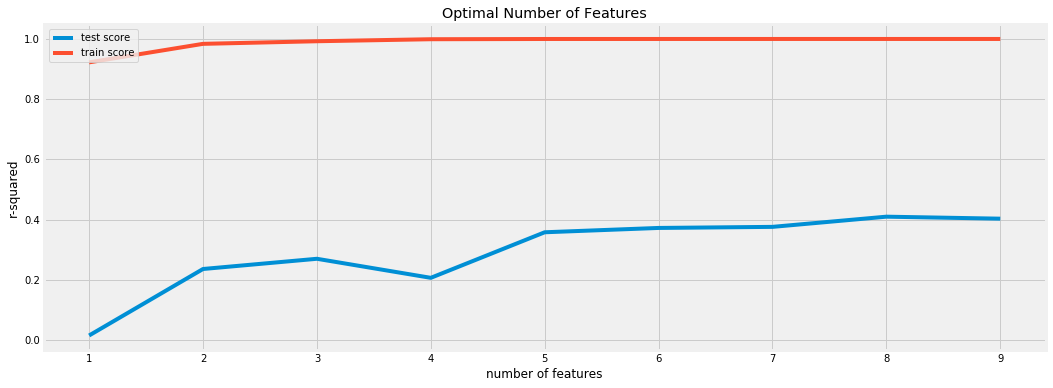

In [30]:
plt.figure(figsize = (16,6))

plt.plot(cv_result["param_n_features_to_select"], cv_result["mean_test_score"])
plt.plot(cv_result["param_n_features_to_select"], cv_result["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [31]:
start_time = time.time()

n_optimal = 8

rfe = RFE(reg_xgb, n_features_to_select = n_optimal)             
reg_xgb_optima_10 = rfe.fit(X_train, y_train)

finish_time = time.time()
total_time = finish_time - start_time

print('Elapsed time: ', total_time)

Elapsed time:  0.27499866485595703


In [32]:
# R2 score model with hold-out set 
print(metrics.r2_score(y_train, reg_xgb.predict(X_train)))
print(metrics.r2_score(y_test, reg_xgb.predict(X_test)))

0.9999978515028485
0.4041698001737801


In [33]:
# R2 score model with optimal XGBoost model 
print(metrics.r2_score(y_train, reg_xgb_optima_10.predict(X_train)))
print(metrics.r2_score(y_test, reg_xgb_optima_10.predict(X_test)))

0.999991186684509
0.4121794862826327


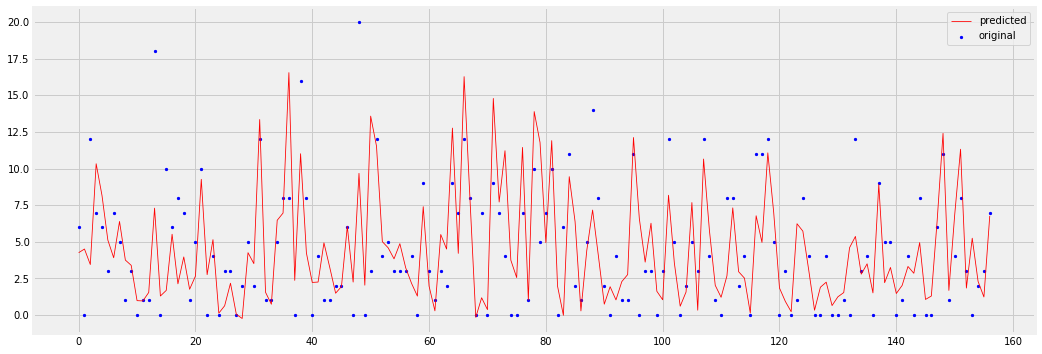

In [34]:
plt.figure(figsize = (16,6))

x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s = 5, color = "blue", label = "original")
plt.plot(x_ax, reg_xgb_optima_10.predict(X_test), lw = 0.8, color = "red", label = "predicted")
plt.legend()
plt.show()

### 2.2.3 Test on whole set

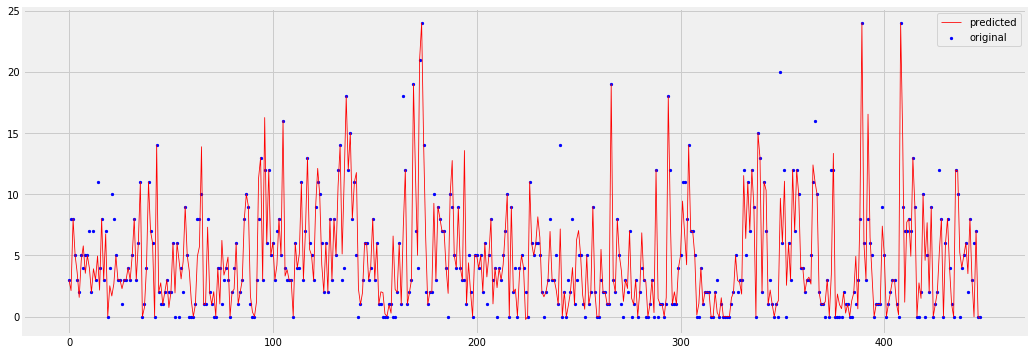

In [35]:
plt.figure(figsize = (16,6))

x_ax = range(len(y))
plt.scatter(x_ax, y, s = 5, color = "blue", label = "original")
plt.plot(x_ax, reg_xgb_optima.predict(X), lw = 0.8, color = "red", label = "predicted")
plt.legend()
plt.show()

In [36]:
df_features_clean['pred_incident'] = reg_xgb_optima.predict(X)

In [37]:
df_features_clean

,TotalResidents,% age 0-15,%Age 65+,AverageSizeofHoushold,Population Density,Building year before 2000,floorsize_accomodation,env_effect,nr_of_monuments,cultuur_en_musea,incident,pred_incident
0,1110.0,4.054054,9.009009,1.4,18349.0,96.0,1716.0,3.0,20.0,4.0,3.0,2.998795
1,695.0,2.877698,10.071942,1.4,7910.0,87.0,117.0,3.0,23.0,3.0,8.0,2.134015
2,1645.0,5.471125,10.942249,1.4,26460.0,96.0,86.0,4.0,12.0,2.0,8.0,7.994024
3,365.0,6.849315,8.219178,1.5,6883.0,98.0,442.0,2.0,69.0,1.0,5.0,5.002687
4,690.0,5.797101,11.594203,1.4,8161.0,100.0,680.0,2.0,32.0,1.0,3.0,3.616330
...,...,...,...,...,...,...,...,...,...,...,...,...
474,1665.0,18.618619,7.507508,1.9,9544.0,100.0,93.0,0.0,0.0,1.0,3.0,3.002095
475,3245.0,13.867488,20.338983,2.3,5109.0,100.0,80.0,1.0,0.0,0.0,6.0,-0.011137
476,3355.0,15.201192,18.777943,2.0,4676.0,100.0,74.0,2.0,0.0,0.0,7.0,6.980494
477,1480.0,17.905405,18.581081,2.3,5099.0,94.0,73.0,4.0,0.0,0.0,0.0,0.009127


In [38]:
print('MAE:', metrics.mean_absolute_error(df_features_clean['incident'], df_features_clean['pred_incident']))
print('MSE:', metrics.mean_squared_error(df_features_clean['incident'], df_features_clean['pred_incident']))
print('RMSE:', np.sqrt(metrics.mean_squared_error(df_features_clean['incident'], df_features_clean['pred_incident'])))

MAE: 0.8210559652985207
MSE: 3.606522614689917
RMSE: 1.899084678125206


In [39]:
f = reg_xgb_optima.get_support(1)
df_features_clean.columns[f] # Most important features from the final model from left to right

Index(['TotalResidents', '%Age 65+', 'AverageSizeofHoushold',
       'Population Density', 'Building year before 2000', 'env_effect',
       'nr_of_monuments', 'cultuur_en_musea'],
      dtype='object')

In [40]:
# R2 score prediction from optimal XGBoost model
print(metrics.r2_score(df_features_clean['incident'], df_features_clean['pred_incident']))

0.8192415255870427


In [41]:
neighborhood = df_features['Neighborhood']
pred_csv = pd.concat([neighborhood, df_features_clean], axis = 1)
pred_csv = pred_csv[['Neighborhood', 'incident', 'pred_incident']]
pred_csv

,Neighborhood,incident,pred_incident
0,Kop Zeedijk,3.0,2.998795
1,Oude Kerk e.o.,8.0,2.134015
2,Burgwallen Oost,8.0,7.994024
3,Nes e.o.,5.0,5.002687
4,BG-terrein e.o.,3.0,3.616330
...,...,...,...
474,Gein Zuidwest,3.0,3.002095
475,Gein Noordoost,6.0,-0.011137
476,Gein Zuidoost,7.0,6.980494
477,Dorp Driemond,0.0,0.009127


In [42]:
pred_csv.to_csv('prediction_output.csv')